Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/Users/edeno/miniconda3/envs/non_local_detector/lib/python3.11/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


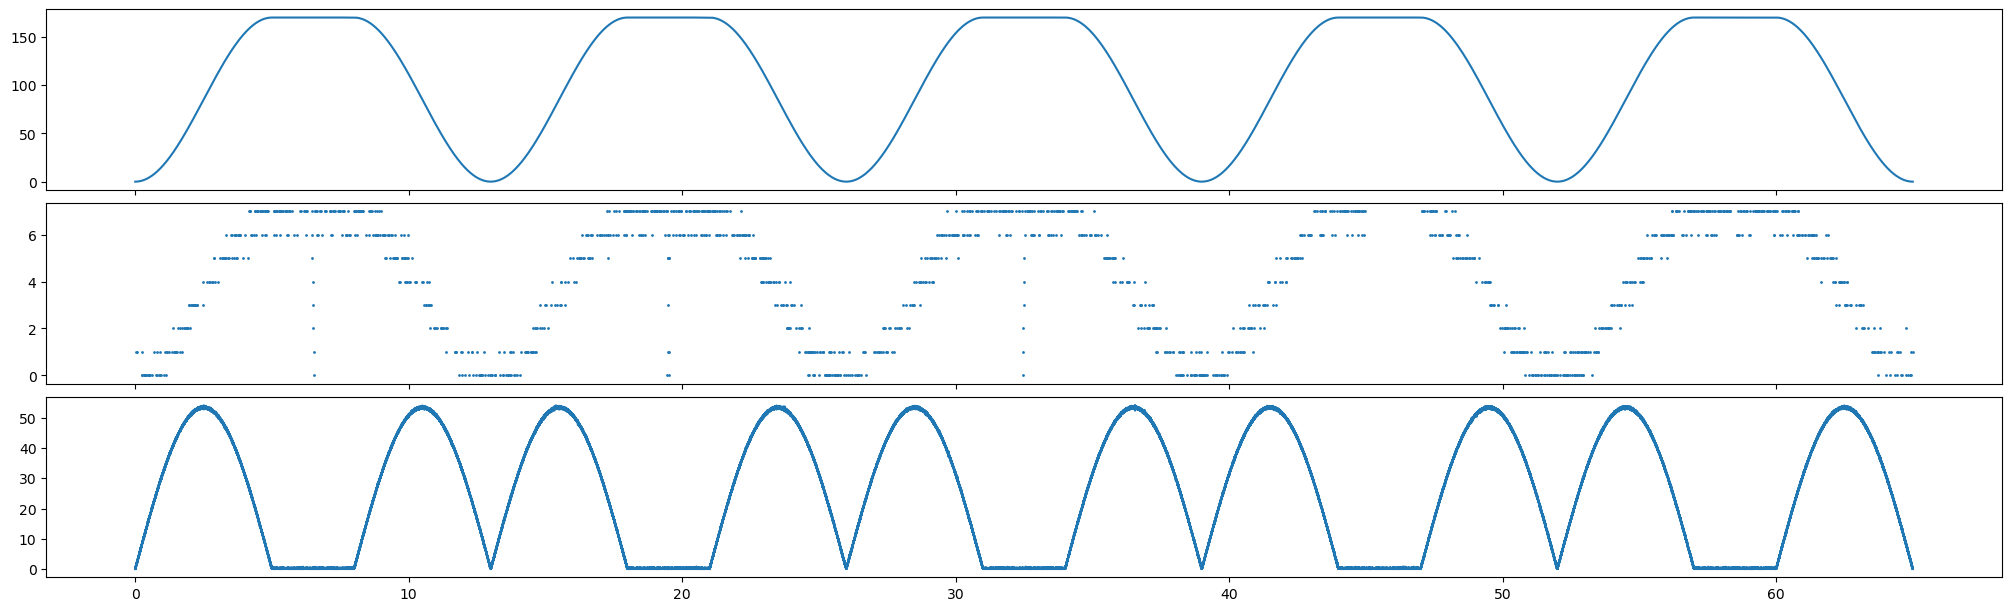

In [1]:
from non_local_detector.simulate.sorted_spikes_simulation import make_simulated_data

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

speed, position, spikes, time, ripple_times, sampling_frequency = make_simulated_data()

is_ripple = np.zeros_like(time, dtype=bool)
for ripple_time in ripple_times:
    is_ripple |= (time >= ripple_time[0]) & (time <= ripple_time[1])


fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(20, 6))
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, speed)

In [2]:
import numpy as np

from non_local_detector import NonLocalSortedSpikesDetector
from non_local_detector.environment import Environment
from non_local_detector.discrete_state_transitions import DiscreteStationaryDiagonal
from non_local_detector.continuous_state_transitions import (
    Discrete,
    Uniform,
    RandomWalk,
)

env = Environment(place_bin_size=2.0)

discrete_state_transition = DiscreteStationaryDiagonal(
    diagonal_values=np.array([0.90, 0.90, 0.90, 0.98])
)

continuous_state_transition = [
    [Discrete(), Discrete(), Uniform(), Uniform()],
    [Discrete(), Discrete(), Uniform(), Uniform()],
    [Discrete(), Discrete(), RandomWalk(movement_var=30.0), Uniform()],
    [Discrete(), Discrete(), Uniform(), Uniform()],
]

stickiness = np.array([100.0, 100_000.0, 100.0, 100.0])

sorted_spikes_algorithm_params = {
    "l2_penalty": 1e-5,
    "emission_knot_spacing": 30.0,
}

detector = NonLocalSortedSpikesDetector(
    environments=env,
    sorted_spikes_algorithm="sorted_spikes_glm_jax",
    sorted_spikes_algorithm_params=sorted_spikes_algorithm_params,
    continuous_transition_types=continuous_state_transition,
    sampling_frequency=sampling_frequency,
    discrete_transition_stickiness=stickiness,
)

is_training = ~is_ripple

detector.fit(position=position, spikes=spikes, is_training=is_training)

  0%|          | 0/8 [00:00<?, ?it/s]

NonLocalSortedSpikesDetector(continuous_initial_conditions_types=[UniformInitialConditions(),
                                                                  UniformInitialConditions(),
                                                                  UniformInitialConditions(),
                                                                  UniformInitialConditions()],
                             continuous_transition_types=[[<non_local_detector.continuous_state_transitions.Discrete object at 0x151df1050>,
                                                           <non_local_detector.continuous_state_transitions.Discrete object at 0x...
                                                                  is_local=False,
                                                                  is_no_spike=False),
                                                 ObservationModel(environment_name='',
                                                                  encoding_group=0,
                                                                  is_local=False,
                                                                  is_no_spike=False)],
                             sampling_frequency=1500,
                             sorted_spikes_algorithm='sorted_spikes_glm_jax',
                             sorted_spikes_algorithm_params={'emission_knot_spacing': 30.0,
                                                             'l2_penalty': 1e-05},
                             state_names=['Local', 'No-Spike',
                                          'Non-Local Continuous',
                                          'Non-Local Fragmented'])

/Users/edeno/miniconda3/envs/non_local_detector/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/edeno/miniconda3/envs/non_local_detector/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


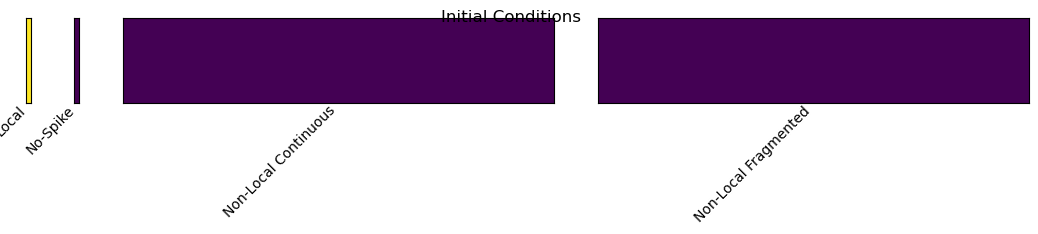

In [3]:
detector.plot_initial_conditions(figsize_scaling=2)

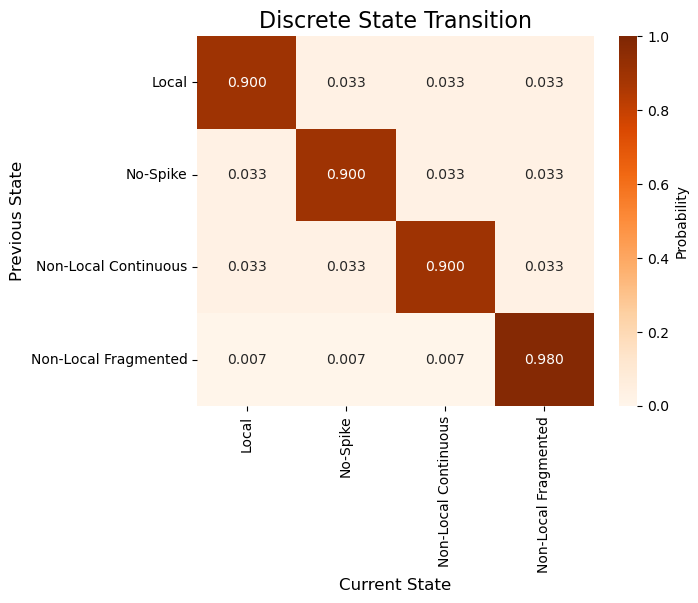

In [4]:
detector.plot_discrete_state_transition()

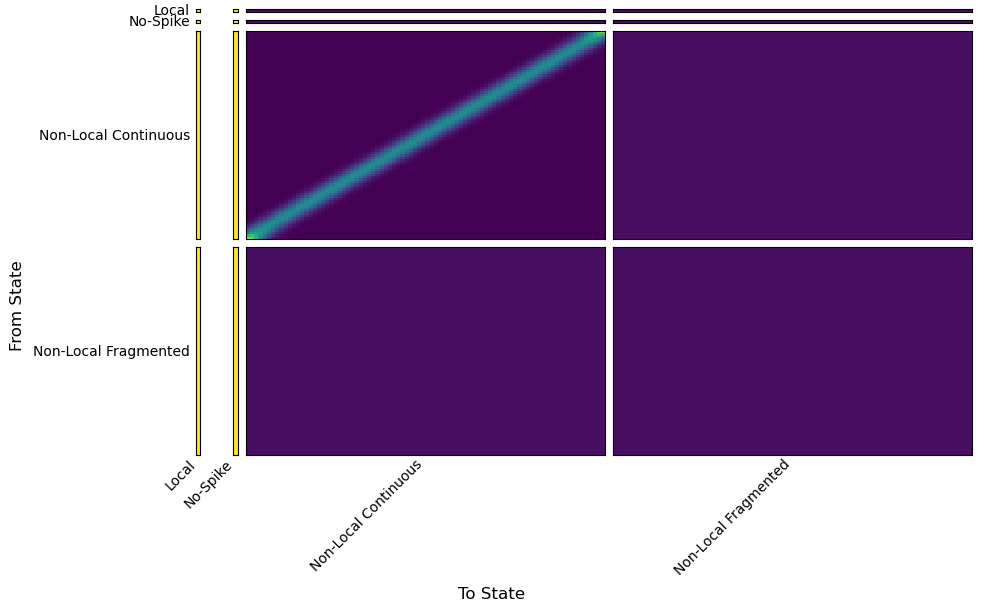

In [5]:
detector.plot_continuous_state_transition()

In [6]:
from non_local_detector import SortedSpikesDecoder

decoder = SortedSpikesDecoder(
    environments=env,
    sorted_spikes_algorithm="sorted_spikes_glm_jax",
    sorted_spikes_algorithm_params=sorted_spikes_algorithm_params,
    sampling_frequency=sampling_frequency,
).fit(position, spikes, is_training=is_training)
decoder_results = decoder.predict(position, spikes).unstack("state_bins").squeeze()
decoder_results

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Causal
Acausal


<xarray.Dataset>
Dimensions:                      (position: 86, time: 97500, state_ind: 86)
Coordinates:
    state                        <U7 'state 0'
  * position                     (position) float64 0.9881 2.965 ... 167.0 169.0
  * time                         (time) float64 0.0 0.0006667 ... 65.0 65.0
  * state_ind                    (state_ind) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    states                       <U7 'state 0'
    environments                 <U1 ''
    encoding_groups              int64 0
Data variables:
    causal_posterior             (time, position) float32 0.01161 ... 1.859e-11
    acausal_posterior            (time, position) float32 0.03936 ... 1.859e-11
    acausal_state_probabilities  (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
Attributes:
    marginal_log_likelihoods:  -10226.953

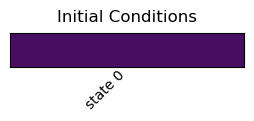

In [7]:
decoder.plot_initial_conditions()

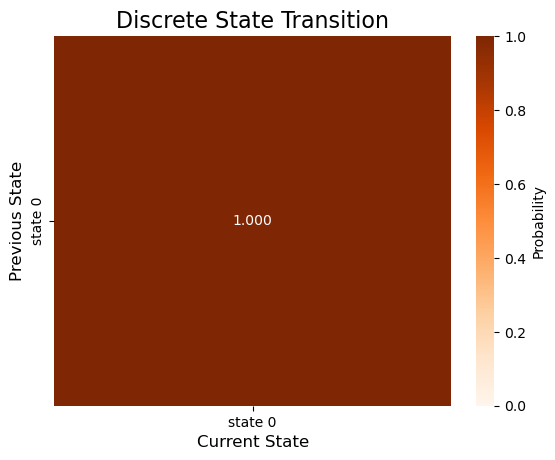

In [8]:
decoder.plot_discrete_state_transition()

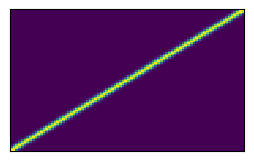

In [9]:
decoder.plot_continuous_state_transition()

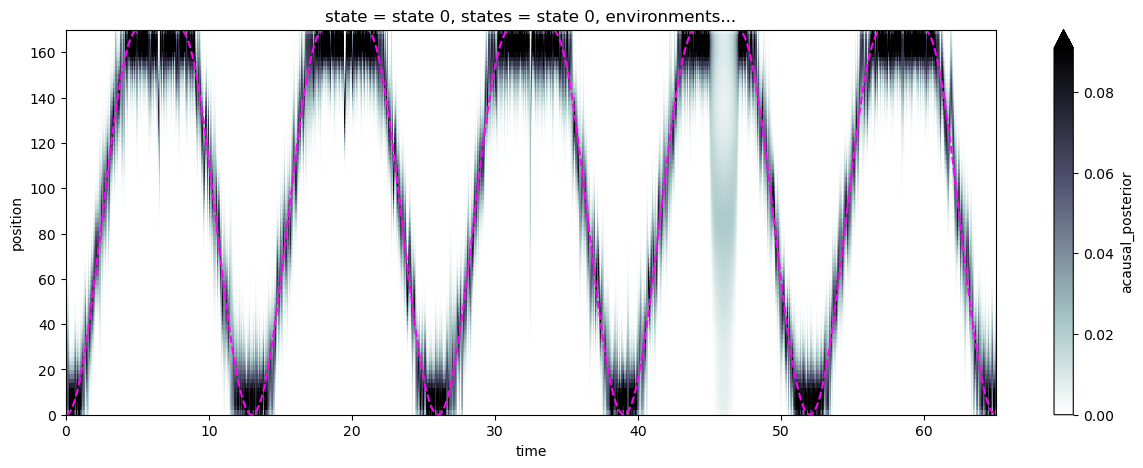

In [10]:
decoder_results.acausal_posterior.plot(
    x="time", y="position", robust=True, cmap="bone_r", aspect=3, size=5
)
plt.plot(decoder_results.time, position, color="magenta", linestyle="--")

In [11]:
from non_local_detector import ContFragSortedSpikesClassifier

cont_frag_classifier = ContFragSortedSpikesClassifier(
    environments=env,
    sorted_spikes_algorithm="sorted_spikes_glm_jax",
    sorted_spikes_algorithm_params=sorted_spikes_algorithm_params,
    sampling_frequency=sampling_frequency,
).fit(position, spikes, is_training=is_training)
cont_frag_results = cont_frag_classifier.predict(position, spikes)
cont_frag_results

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Causal
Acausal


<xarray.Dataset>
Dimensions:                      (time: 97500, state_bins: 172, states: 2,
                                  state_ind: 172)
Coordinates:
  * time                         (time) float64 0.0 0.0006667 ... 65.0 65.0
  * state_bins                   (state_bins) object MultiIndex
  * state                        (state_bins) object 'Continuous' ... 'Fragme...
  * position                     (state_bins) float64 0.9881 2.965 ... 169.0
  * state_ind                    (state_ind) int64 0 0 0 0 0 0 0 ... 1 1 1 1 1 1
  * states                       (states) <U10 'Continuous' 'Fragmented'
    environments                 (states) <U1 '' ''
    encoding_groups              (states) int64 0 0
Data variables:
    causal_posterior             (time, state_bins) float32 0.005806 ... 0.00...
    acausal_posterior            (time, state_bins) float32 0.01388 ... 0.004567
    acausal_state_probabilities  (time, states) float64 0.5212 0.4788 ... 0.3928
Attributes:
    marginal_log_likelihoods:  -11213.376

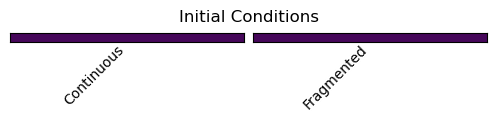

In [12]:
cont_frag_classifier.plot_initial_conditions()

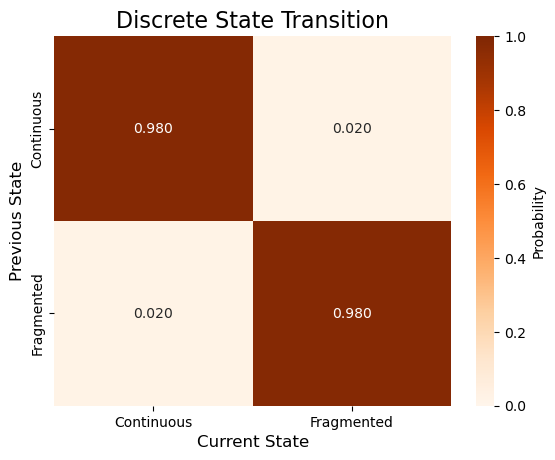

In [13]:
cont_frag_classifier.plot_discrete_state_transition()

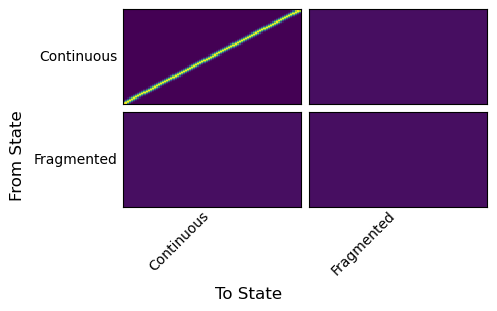

In [14]:
cont_frag_classifier.plot_continuous_state_transition()

In [15]:
from replay_trajectory_classification import SortedSpikesClassifier as RTCClassifier

rtc = RTCClassifier(environments=env,
                    sorted_spikes_algorithm="spiking_likelihood_glm",
                    sorted_spikes_algorithm_params = {
                        "penalty": 1e-5,
                        "knot_spacing": 30.0,
                    }
                    ).fit(position[:, np.newaxis], spikes)
rtc_results = rtc.predict(spikes, state_names=["Continuous", "Fragmented"], time=decoder_results.time)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/edeno/miniconda3/envs/non_local_detector/lib/python3.11/site-packages/replay_trajectory_classification/core.py:205: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'F', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  discrete_state_transition[state_k, state_k_1]


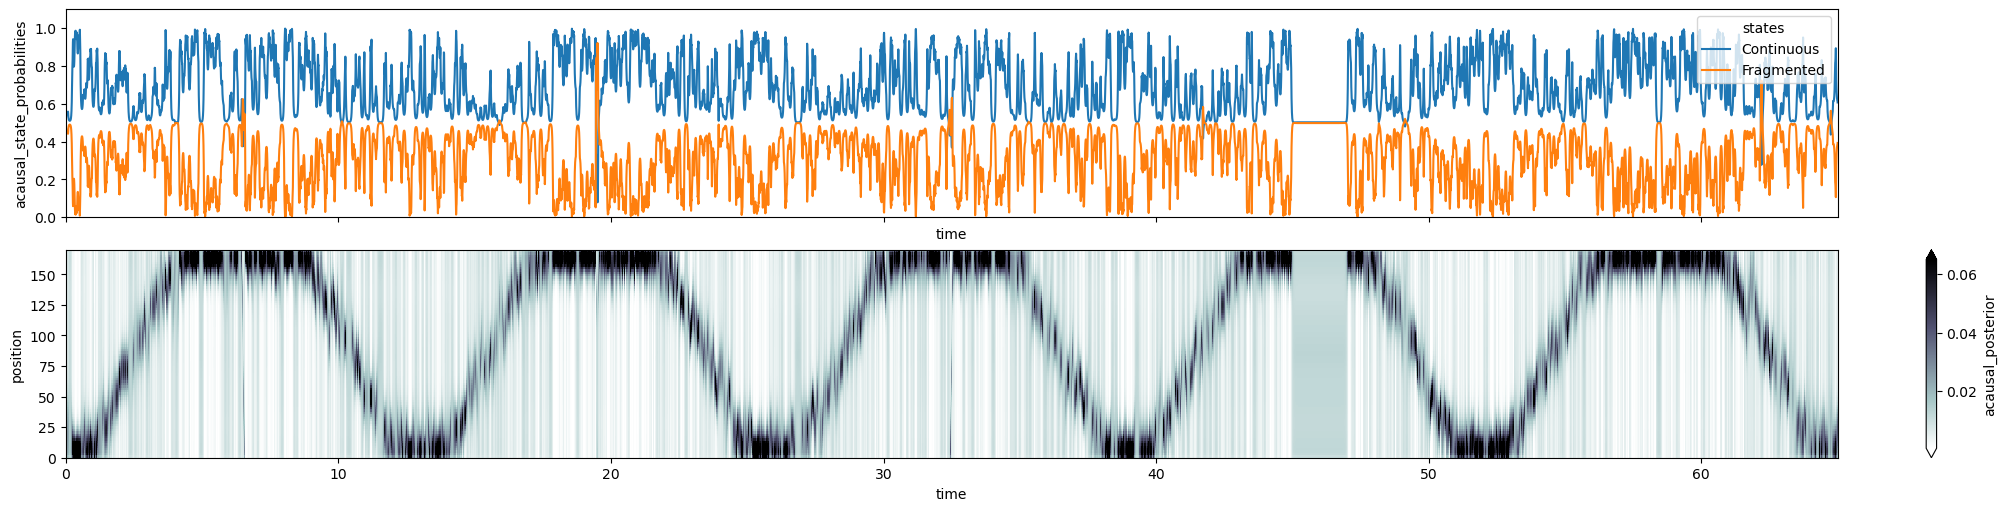

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(20, 5), sharex=True, constrained_layout=True)
cont_frag_results.acausal_state_probabilities.plot(x="time", hue="states", ax=axes[0])
axes[0].set_ylim((0, 1.1))
cont_frag_results.unstack("state_bins").acausal_posterior.sum("state").plot(
    x="time", y="position", robust=True, cmap="bone_r", ax=axes[1]
)

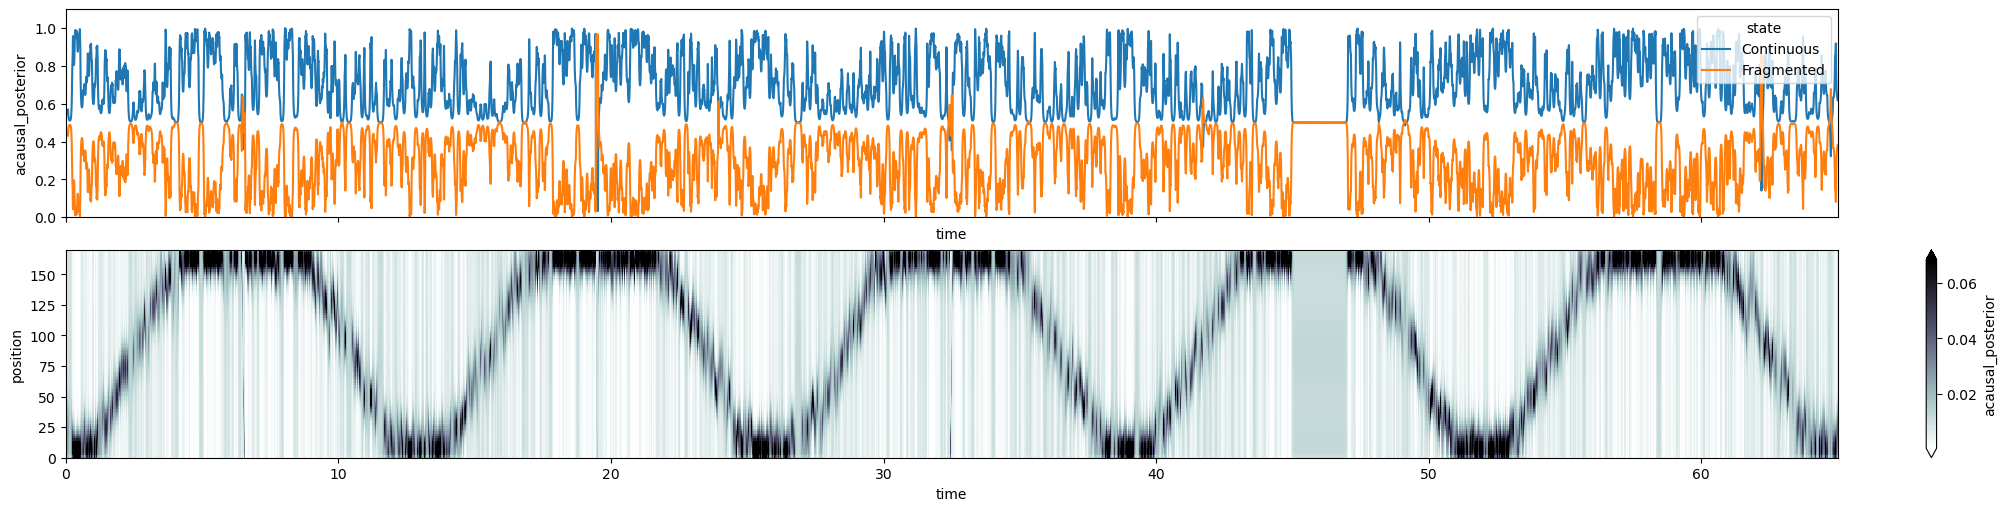

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(20, 5), sharex=True, constrained_layout=True)
rtc_results.acausal_posterior.sum("position").plot(x="time", hue="state", ax=axes[0])
axes[0].set_ylim((0, 1.1))
rtc_results.acausal_posterior.sum("state").plot( x="time", y="position", robust=True, cmap="bone_r", ax=axes[1])

In [18]:
import xarray as xr

xr.merge((rtc_results.acausal_posterior.sum("position").rename("acausal_state_probabilities"), rtc_results.acausal_posterior.sum("state")))

<xarray.Dataset>
Dimensions:                      (time: 97500, state: 2, position: 86)
Coordinates:
  * time                         (time) float64 0.0 0.0006667 ... 65.0 65.0
  * state                        (state) <U10 'Continuous' 'Fragmented'
  * position                     (position) float64 0.9881 2.965 ... 167.0 169.0
Data variables:
    acausal_state_probabilities  (time, state) float64 0.5257 0.4743 ... 0.3811
    acausal_posterior            (time, position) float64 0.01969 ... 0.004528

In [19]:
xr.merge((rtc_results.acausal_posterior.sum("position").rename("acausal_state_probabilities"), rtc_results.acausal_posterior))

<xarray.Dataset>
Dimensions:                      (time: 97500, state: 2, position: 86)
Coordinates:
  * time                         (time) float64 0.0 0.0006667 ... 65.0 65.0
  * state                        (state) <U10 'Continuous' 'Fragmented'
  * position                     (position) float64 0.9881 2.965 ... 167.0 169.0
Data variables:
    acausal_state_probabilities  (time, state) float64 0.5257 0.4743 ... 0.3811
    acausal_posterior            (time, state, position) float64 0.01417 ... ...

In [23]:
cont_frag_results

<xarray.Dataset>
Dimensions:                      (time: 97500, state_bins: 172, states: 2,
                                  state_ind: 172)
Coordinates:
  * time                         (time) float64 0.0 0.0006667 ... 65.0 65.0
  * state_bins                   (state_bins) object MultiIndex
  * state                        (state_bins) object 'Continuous' ... 'Fragme...
  * position                     (state_bins) float64 0.9881 2.965 ... 169.0
  * state_ind                    (state_ind) int64 0 0 0 0 0 0 0 ... 1 1 1 1 1 1
  * states                       (states) <U10 'Continuous' 'Fragmented'
    environments                 (states) <U1 '' ''
    encoding_groups              (states) int64 0 0
Data variables:
    causal_posterior             (time, state_bins) float32 0.005806 ... 0.00...
    acausal_posterior            (time, state_bins) float32 0.01388 ... 0.004567
    acausal_state_probabilities  (time, states) float64 0.5212 0.4788 ... 0.3928
Attributes:
    marginal_log_likelihoods:  -11213.376